<a href="https://colab.research.google.com/github/Koo82/ML/blob/main/h_10_%E1%84%89%E1%85%B5%E1%84%80%E1%85%A8%E1%84%8B%E1%85%A7%E1%86%AF%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5%E1%84%8E%E1%85%A5%E1%84%85%E1%85%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시계열 데이터 처리

- 시계열 데이터 분석의 목적
 - 1) 미래 시계열 값의 예측 (forecasting)
 - 2) 시계열 패턴을 분류 (정상, 고장, 위험 등)
- 시계열 데이터 유형
 - 1) 각 샘플이 날짜나 시각 (연월일 시분초) 정보를 포함하고 있는 경우
 - 2) 시각 정보 없이 샘플 값만 나열된 경우 (대부분 샘플링 간격이 일정하다)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# datetime
- 연월일 시분초 정보를 다루는 특수 데이터 구조체

In [2]:
# 현재 시각 얻기
from datetime import datetime
t1 = datetime.now()
t1

datetime.datetime(2021, 5, 11, 5, 16, 37, 959577)

In [3]:
# 연월일 시분초 정보 얻기
t1.year, t1.month, t1.day, t1.hour, t1.minute, t1.second

(2021, 5, 11, 5, 16, 37)

In [4]:
# 요일 보기 0~7, 월 ~ 일
t1.weekday()

1

In [5]:
# 포맷을 바꾸어 표현하기
d = "{1}/{2}/{0}".format(t1.year, t1.month, t1.day)
d

'5/11/2021'

In [6]:
# 새로운 datetime 객체 만들기
new_time = datetime(2021, 12, 31, 11)
new_time

datetime.datetime(2021, 12, 31, 11, 0)

In [7]:
# 시간 차이 구하기 (timedelta을 얻음)
delay = datetime.now() - t1
delay

datetime.timedelta(seconds=150, microseconds=552479)

## to_datetime
- 컬럼명이 year, month, day 인 데이터프레임을 datetime 형식으로 변환해준다

In [8]:
df = pd.DataFrame({'year': [2021, 2022, 2023],
                   'month': [2, 3, 4],
                   'day': [9, 11, 23]})
df

,year,month,day
0,2021,2,9
1,2022,3,11
2,2023,4,23


In [9]:
date = pd.to_datetime(df)
date

0   2021-02-09
1   2022-03-11
2   2023-04-23
dtype: datetime64[ns]

In [10]:
%timeit pd.to_datetime(df)

The slowest run took 7.21 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 1.77 ms per loop


In [11]:
# 날짜 데이터를 직접 생성하는 방법 (네자리 연도는 Y로 표시)
pd.to_datetime('20210901', format='%Y%m%d', errors='ignore')

Timestamp('2021-09-01 00:00:00')

In [12]:
# 두자리 연도는 y로 표시
pd.to_datetime('210901', format='%y%m%d', errors='ignore') #ok

Timestamp('2021-09-01 00:00:00')

## date_range
- 날짜 데이터의 범위(기간)을 하나의 변수로 표현

In [13]:
date = pd.date_range(start='2021-1-1', end='2021-12-31')
print(len(date))
date

365


DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

In [15]:
# datetime 형식 데이터는 데이터프레임으로 바로 만들 수 있다
pd.DataFrame({'date':date})

,date
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05
...,...
360,2021-12-27
361,2021-12-28
362,2021-12-29
363,2021-12-30


# 일반 시계열 데이터

## 날씨 데이터

In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/new_weather.csv')
print(df.shape)
df[:5]

(4018, 4)


,연월일,기온,품질,균질
0,2006/1/1,3.6,8,1
1,2006/1/2,4.0,8,1
2,2006/1/3,3.7,8,1
3,2006/1/4,4.0,8,1
4,2006/1/5,3.6,8,1


In [17]:
# '연월일' 컬럼이 datetime 타입이 아니다 (단순히 문자열임)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   연월일     4018 non-null   object 
 1   기온      4018 non-null   float64
 2   품질      4018 non-null   int64  
 3   균질      4018 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 125.7+ KB


## 훈련, 검증 데이터 나누기
- 과거 기온 변화 정보를 사용하여 미래값을 예측한다 (time series forcasting)
- 모델은 선형예측 (linear regression)을 기본적으로 사용한다
 - ARIMA, Prophet 등 다른 예측 모델이 있다 (시계열 분석에서 다룸)
- 시계열 데이터는 순서를 유지해야 의미가 있으므로 랜덤하게 섞으면 안된다
 - 일반적으로 train_test_split을 사용하지 않는다
 - 보통 앞부분의 데이터로 훈련을 시키고 뒷 부분의 데이터로 검증한다

In [18]:
y = df["기온"].values
len(y)

4018

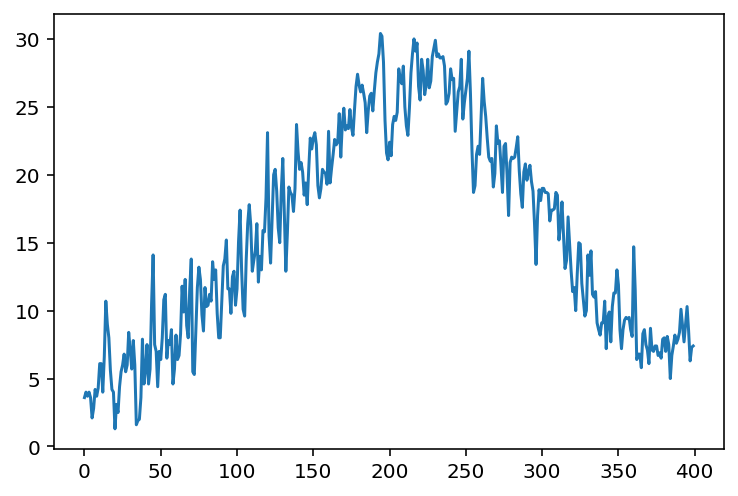

In [19]:
plt.plot(y[:400])

- 훈련 데이터 검증 데이터 나누기

In [20]:
# 전체 시계열 데이터중 앞부분 75%를 훈련 데이터로, 나머지를 검증 데이터로 나누는 예
ratio = 0.75
cut = np.int(len(y)*ratio)
train = y[:cut]
test = y[cut:]
len(y), len(train), len(test)

(4018, 3013, 1005)

# 선형 예측 모델


- 과거 샘플 값을 보고 미래 값을 예측

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-09%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.16.26.png?raw=1" width=450 align='left'>

- 선형 회귀 (linear regression) 모델 사용


 > $\hat{y_{n}} = b +a_{1}y_{n-1} + a_{2}y_{n-2} + a_{3}y_{n-3} + ...$

## walk forward 예측
- 내일이 되면 내일 기온을 알 수 있으므로 모레 기온을 예측하는데 내일 데이터를 사용할 수 있다. 이러한 방법을 walk forward 예측이라고 한다

## 시계열 데이터를 테이블 구조로 만들기
- 시계열 분석에서 머신러닝 모델을 쉽게 적용하기 위해서 비정형인(크기가 일정치 않은) 시계열 데이터를 정형 데이터인 테이블 구조로 만드는 경우가 많다
- 아래는 5개의 시계열 데이터를 보고 6번째 값을 예측하는 경우이며 walk forward 예측을 위한 테이블을 보였다


<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-08%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%203.44.24.png?raw=1" width=600 aligh='left'>

## split_seq()
- 시계열 데이터를 테이블 구조로  표현하는 작업을 수행
 - data는 입력 시계열 데이터 (위 그림에서 len(data)=13임)
 - n_steps는 한 샘플의 크기 (위 그림에서 5)

In [21]:
def split_seq(data, n_steps):
    x, y = [], []
    for i in range(len(data)):
        if i > len(data) - (n_steps + 1) : break
        x.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(x), np.array(y)

In [22]:
# 예: 과거 5개의 샘플을 보고 다음 값을 예측하기 위한 훈련데이터 X, y 생성
data = [1,2,3,4,5,6,7,8,9,10,11,12,13]
x_train, y_train = split_seq(data, 5)

pd.DataFrame(list(zip(x_train, y_train)), columns=['X','y'])

,X,y
0,"[1, 2, 3, 4, 5]",6
1,"[2, 3, 4, 5, 6]",7
2,"[3, 4, 5, 6, 7]",8
3,"[4, 5, 6, 7, 8]",9
4,"[5, 6, 7, 8, 9]",10
5,"[6, 7, 8, 9, 10]",11
6,"[7, 8, 9, 10, 11]",12
7,"[8, 9, 10, 11, 12]",13


In [27]:
list(zip(x_train, y_train))

[(array([1, 2, 3, 4, 5]), 6),
 (array([2, 3, 4, 5, 6]), 7),
 (array([3, 4, 5, 6, 7]), 8),
 (array([4, 5, 6, 7, 8]), 9),
 (array([5, 6, 7, 8, 9]), 10),
 (array([ 6,  7,  8,  9, 10]), 11),
 (array([ 7,  8,  9, 10, 11]), 12),
 (array([ 8,  9, 10, 11, 12]), 13)]

In [28]:
for xx, yy in zip(x_train, y_train):
  print(xx, yy)

[1 2 3 4 5] 6
[2 3 4 5 6] 7
[3 4 5 6 7] 8
[4 5 6 7 8] 9
[5 6 7 8 9] 10
[ 6  7  8  9 10] 11
[ 7  8  9 10 11] 12
[ 8  9 10 11 12] 13


## 선형 회귀 예측 모델 

In [29]:
# 선형 회귀 모델 함수
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# 과거 10일 기온 데이터를 사용하여 내일 기온을 예측하는 경우
n_steps = 10
# 훈련 데이터
x_train, y_train = split_seq(train, n_steps)
# 검증 데이터
x_test, y_test = split_seq(test, n_steps)
# 훈련 수행
lr.fit(x_train, y_train) 
# 선능 평가: 회귀에서는 디폴트로 R-Squared 점수를 알려준다 (뒤에서 설명함)
lr.score(x_test, y_test).round(4) 

0.936

In [30]:
# 훈련 및 검증 데이터 크기 (윈도우 크기 N=10 참고)
len(x_train), len(x_test)

(3003, 995)

In [31]:
# 실제값(y_test)과 예측값(y_pred) 비교
y_pred = lr.predict(x_test)
pd.DataFrame({"y_test":y_test, "y_pred":y_pred.round(2)})[:5]

,y_test,y_pred
0,14.6,12.63
1,14.4,14.71
2,14.0,14.08
3,16.3,13.98
4,18.7,15.81


### 예측 결과 그래프

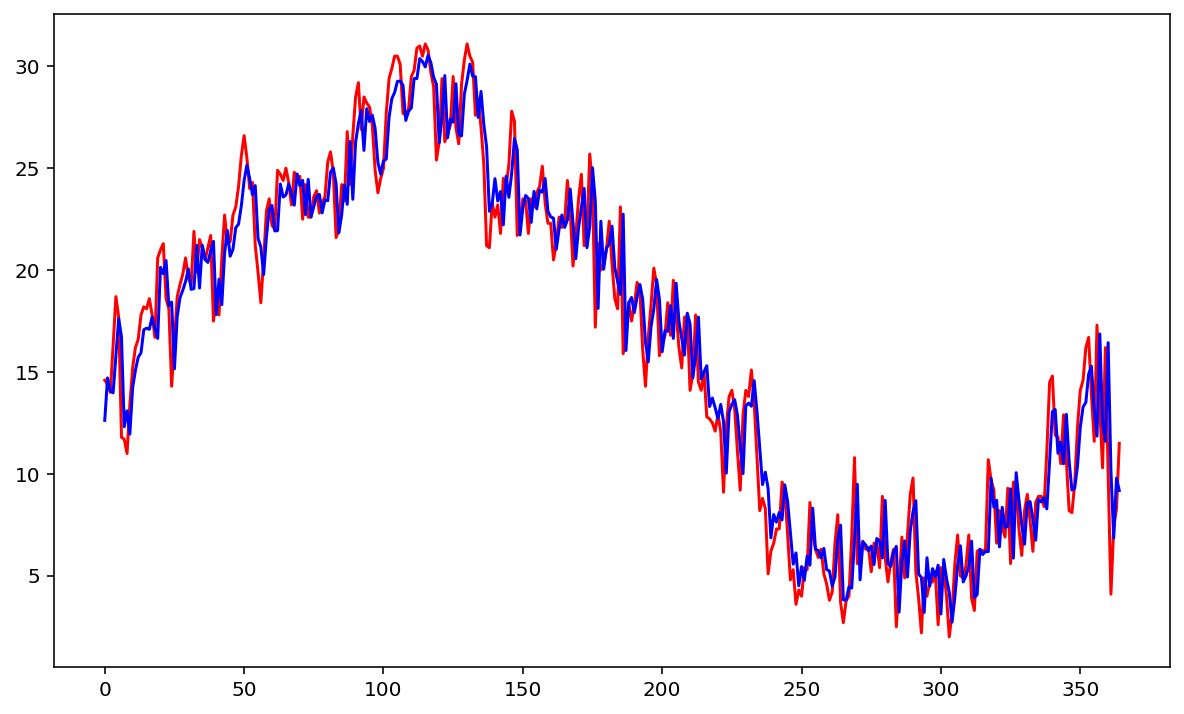

In [32]:
# 실제값 붉은색, 예측값 파란색
plt.figure(figsize=(10, 6))
plt.plot(y_test[:365], c='r')
plt.plot(y_pred[:365], c='b')
plt.show()

In [33]:
# 선형 예측 모델 계수 (가중치) - 가장 최근의 값에 곱해지는 계수가 가장 크다 (아래에서 마지막 계수)
lr.coef_

array([ 0.04199142,  0.03098722,  0.00984958,  0.04929182,  0.03011167,
        0.04455212,  0.00230516,  0.11047411, -0.16003639,  0.82663927])

In [34]:
lr.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

# 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error  
 - MSE: mean squared error    
 - RMSE: root MSE  

$MAE = $$1\over{N}$$ \sum |y_{i} - \hat{y}|$

$MSE = $$1\over{N}$$ \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1$-$\sum(y_{i}-\hat{y})^{2}\over{\sum(y_{i}-\bar{y})^{2}}$ $= 1$-$MSE\over{Variance}$  
 >  $y$ :  실제값  
 >  $\hat{y}$ :  예측치  
 >  $\bar{y}$ :  평균치
 
 ### R-Squared
- 회귀 성능의 기본적인 평가 지표
- MSE를 분산으로 정규화한 값을 사용한다
- R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

In [35]:
# 선형 회귀 예측의 여러가지 성능 평가 지표
error = np.abs(y_pred - y_test)
print("오류중 최대값=", max(error))
print("MAE (Mean Absolute Error) =", error.mean())
print("R-Squared =",lr.score(x_test, y_test))

오류중 최대값= 8.613561682545193
MAE (Mean Absolute Error) = 1.4978971246793522
R-Squared = 0.9359804760059094
